Anthony Stevens - 20393264

Erik Derohanian - 20415729

# Lab 2

## Imports and image loading

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
from PIL import ImageFilter
import PIL.ImageOps
import numpy as np
from scipy import ndimage
from scipy import signal
from skimage.util import random_noise

In [2]:
cam = Image.open('cameraman.tif', mode='r').convert(mode="L")
lena = Image.open('lena.tiff', mode='r').convert(mode="L")
grayscale = Image.open('Grayscale.tif', mode='r').convert(mode="L")

In [3]:
def gaussian_noise(im, var=0.002):
    noisy = random_noise(np.array(im), mode='gaussian', var=var)
    return Image.fromarray(np.uint8(noisy*255))

def salt_pepper_noise(im, amount=0.05):
    noisy = random_noise(np.array(im), mode='s&p', amount=amount)
    return Image.fromarray(np.uint8(noisy*255))

def speckle_noise(im, var=0.04):
    noisy = random_noise(np.array(im), mode='speckle', var=var)
    return Image.fromarray(np.uint8(noisy*255))

In [4]:
def MSE(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
  
    im1_data = np.array(im1, dtype=np.int32).flatten()
    im2_data = np.array(im2, dtype=np.int32).flatten()
    
    M = len(im1_data)
    
    MSE = np.power(np.subtract(im1_data, im2_data), 2).sum() / M
    return MSE

def PSNR(im1, im2):
    assert im1.size == im2.size and im1.mode == im2.mode
    mse = MSE(im1, im2)
    if mse == 0:
        return math.inf
    return 10 * math.log10(65025.0 / mse) # 255^2 = 65025

def plot_histogram(im, title):
    im_hist = im.histogram()
    plt.bar([i for i in range(256)], im_hist)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

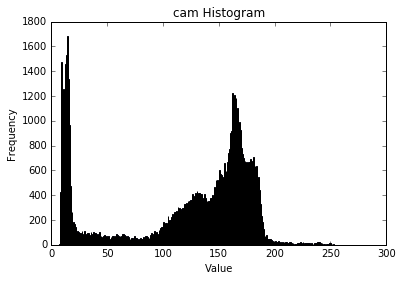

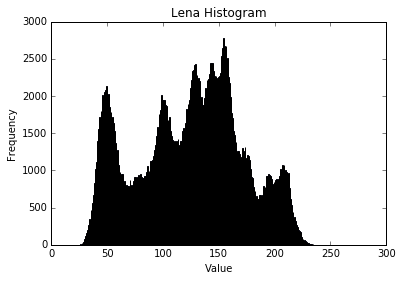

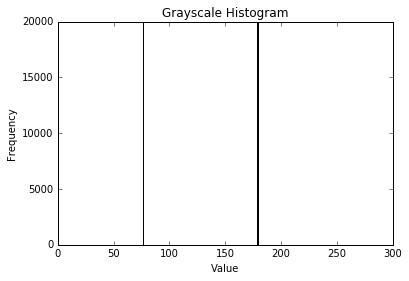

In [5]:
%matplotlib inline
plot_histogram(cam, "cam Histogram")
plot_histogram(lena, "Lena Histogram")
plot_histogram(grayscale, "Grayscale Histogram")

# Noise Generation

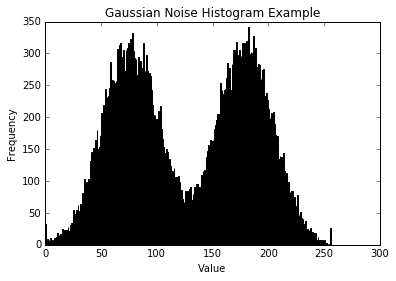

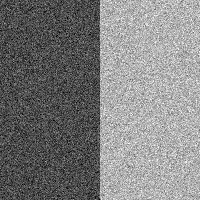

In [6]:
%matplotlib inline
grayscale_gaus = gaussian_noise(grayscale, 0.01)
plot_histogram(grayscale_gaus, "Gaussian Noise Histogram Example")
grayscale_gaus

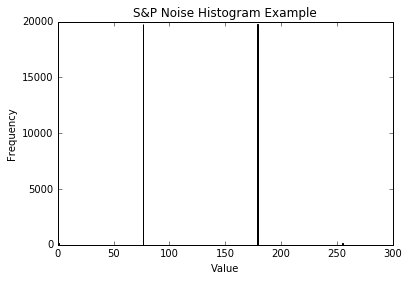

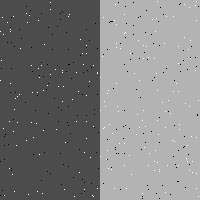

In [7]:
grayscale_sp = salt_pepper_noise(grayscale, 0.01)
plot_histogram(grayscale_sp, "S&P Noise Histogram Example")
grayscale_sp

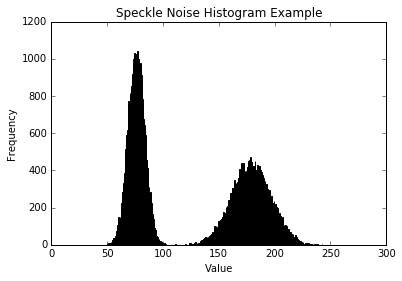

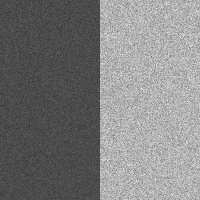

In [8]:
grayscale_speckle = speckle_noise(grayscale, 0.01)
plot_histogram(grayscale_speckle, "Speckle Noise Histogram Example")
grayscale_speckle

## Noise generation Questions

**1. Describe each of the histograms in the context of the corresponding noise models. Why do they appear
that way?**

_Gaussian Noise_: In the histogram, we see two gaussian distributions centered around the two grey values. This is because each pixel has some vallue added to it that is drawn from a gaussian distribution centered at zero.

_Salt & Pepper Noise_: We see the same peaks at the two original grey values, but we also see small peaks at 0 and 255 due to setting some pixels to black or white.

_Speckle Noise_: Similar to the gaussian noise, but instead of adding the noise directly, it multiplies the value by the value of the pixel before adding it. This is why the lighter peak has a wider and shorter distribution, as the multiplication by the higher value spreads out the distribution further apart. (skimage pulls the random number from a gaussian distribution instead of a uniform distribution which is what matlab does. If it pulled from uniform, we would see a taller narrower box centered at the darker peak and a shorter, wider rectangle centered at the lighter peak.)

**2. Are there visual differences between the noise contaminated images? What are they? Why?**

S&P Noise clearly shows black and white pixels because that's what it does. The gaussian and speckled images are much more similar. the gaussian image seems to have higher contrast with both lighter and darker pixels in each respective half, this is due to the wider distribution from which the noise is drawn.

**3. In the speckle noise case, what is the underlying distribution used? Can you tell from the histogram?
How?**

Pythons skimage library uses a gaussian distribution, unlike matlab which uses a uniform distribution. You can tell from the histogram as there are two gaussian distributions centered around the two peaks.

**4. In the speckle noise case, you will notice that the peaks of the histogram are no longer of the same
height as they were in the original image.  Also, the spread around each of the peaks is also different
from each other. Why? Hint: Noise is multiplicative.**

The formula for speckle noise is:

p_new = p + n*p

where p is the original pixel value and n is the random noise value. for larger p, the second term in that equation grows larger meaning you are changing your pixel value by a greater amount, hence the wider and shorter distribution.

# Noise Reduction in the Spatial Domain

PSNR between Lena and noisy Lena: 26.990990972283893


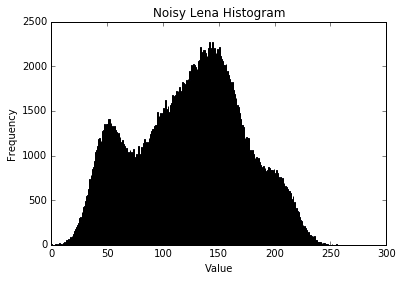

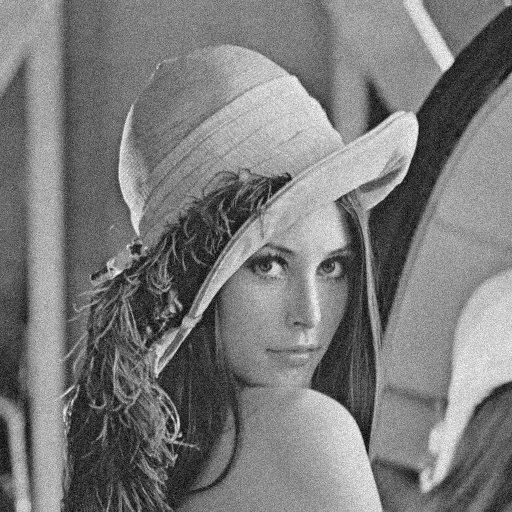

In [9]:
%matplotlib inline
noisy_lena = gaussian_noise(lena)
print("PSNR between Lena and noisy Lena: " + str(PSNR(lena, noisy_lena)))

plot_histogram(noisy_lena, "Noisy Lena Histogram")

noisy_lena

### Noisy lena convolved with 3x3 averaging filter:

3x3 averaging filter:


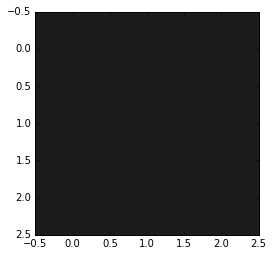

In [10]:
avg_3_3 = (1/9)*np.ones([3,3])
noisy_lena_avg1 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_3_3), 'L')

print("3x3 averaging filter:")
imshow(Image.fromarray(np.uint8(avg_3_3*255),'L'), cmap="gray", vmin=0, vmax=255)

PSNR between Lena and averaged Lena: 31.82551923649209

3x3 Averaging Filter Result:


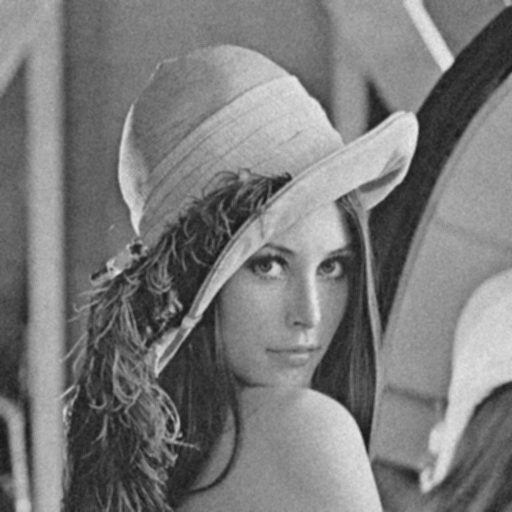

In [11]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg1)) + "\n")

print("3x3 Averaging Filter Result:")
noisy_lena_avg1

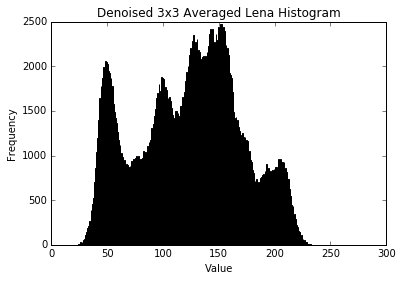

In [12]:
plot_histogram(noisy_lena_avg1, "Denoised 3x3 Averaged Lena Histogram")

**1. Compare the visual difference between the noisy image and the denoised image. How well did it work? Why? Did the PSNR decrease?**

The second (denoised) image is smoother and has more gradual color. The original noisy image is still very sharp but has very clear breakups in same colour areas. So the second image is more consistent in regards to colour but has a much smoother look overall.

This effect is beecause the averaging filter takes into account the pixels around the center. This means that strong edges (where color changes) will end up being an average of the two values on either side of the edges. This averaging is effective for consistent color area but not good for edges. 

The PSNR did not decrease rather it increased. This corroborated by the histograms of each. 

**2. Compare the histograms of the noise-free, noisy and de-noised images. What happened? Why?**

The histograms of the noise-free and de-noised images are much closer to each other. The main difference between the two is that the noisefree histograms is alot less smoothed out along the peaks and valleys. However both histograms share the same basic shapes and global max/min. Also the range of the two is very similar (~40 to ~230).

Those two histograms are very different than the noisy histogram. The noisy histogram is very smooth with only two peaks and a range that goes from 0 to 255. This is because the Gaussian noise will make sure that pixels for all values (even if they are minimal). Because of this we see the noisy histograms records values for all intensities which is very different from the other two. 

**3. Based on the visual quality of the denoised image, what are the benefits and drawbacks associated with the average filter?**

The 3x3 averaging filter does a good job of returning the intensity distribution and levels to their original values in the image. This is shown in the image by better intensity quality in large areas of similar color and in the histogram comparision.

However the 3x3 filter creates a lot of smoothing and edge dissolution. This is because as discussed earlier taking the average around edges causes sharp edges to lower their intensity and thus become less 'sharp'.

### Noisy lena convolved with 7x7 averaging filter:

7x7 averaging filter:


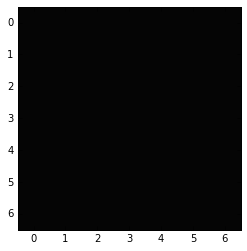

In [13]:
avg_7_7 = (1/49)*np.ones([7,7])

noisy_lena_avg2 = Image.fromarray(ndimage.convolve(np.array(noisy_lena), avg_7_7), 'L')

print("7x7 averaging filter:")
imshow(Image.fromarray(np.uint8(avg_7_7*255),'L'), cmap="gray", vmin=0, vmax=255)

PSNR between Lena and averaged Lena: 27.388998199984947

7x7 Averaging Filter Result:


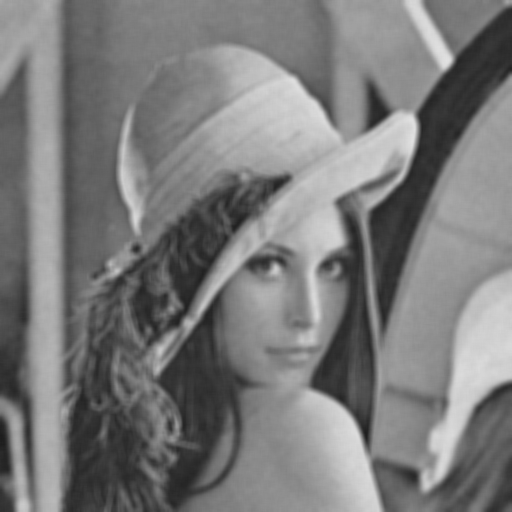

In [14]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, noisy_lena_avg2)) + "\n")
print("7x7 Averaging Filter Result:")
noisy_lena_avg2

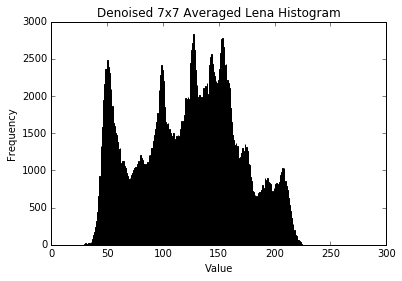

In [15]:
plot_histogram(noisy_lena_avg2, "Denoised 7x7 Averaged Lena Histogram")

**1. Compare the visual difference between the denoised image from the 7x7 filtering kernel and the denoised image from the 3x3 filtering kernel. Are there any differences? Why? Did the PSNR decrease? Why?**

Basically all the effects we talked about in the last question are increased. The color in the 7x7 filteredimage is much more consistent across large areas and matches the original image more. As such the image matches the original in intensity much more than the noisy image. However the smoothing effect is also drastically increased in 7x7 than the 3x3. This is because the 7x7 filter takes an average of a much larger area meaning the edges will be more blurred. 

The PSNR for the 7x7 image is slightly better than the PSNR for the noisy image, however it is a lot lower than the PSNR of the 3x3 filter from the last section. This is because all of the pxiels have been averaged out in a much greater area meaning each pixel is the average of a greater number of further pixels which are less likely to be similar to the "true" value at the desired pixel.

**2. Compare the histograms of the two denoised images. What are the differences? Why?**

The peaks on the 7x7 are much more pronounced as the range of values has decreased however the number of pixels has remained the same. This is because the 7x7 filter will drive more pixels to reflect those around them. Because of this we see a much greater amount of pixels at the dominant intensities (or peaks) and less of a range of values. 

This is again because the 7x7 takes into account a much larger meaning that the pixels will be much more likely to drive to the most common value in a region regardless of the edges or actual color shifts. 

**3. Based on the visual quality of the denoised image, what are the benefits and drawbacks associated with using a larger windows size?**

The 7x7 filter seems to have worse results than the 3x3 filter. The 3x3 filter has much better edges while providing improvements to overall intensity range of the image. However the 7x7 drastically over smoothes the image, to the point where it is very noticeable to the human eye. 

### Gaussian 7x7 filter:

7x7 gaussian filter:


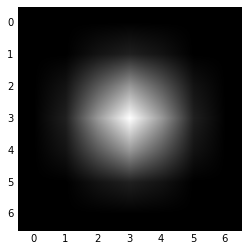

In [16]:
gaus =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]])
# array copied from matlab because python
# doesn't have a direct 'fspecial' equivalent

gaus_denoised = Image.fromarray(ndimage.convolve(np.array(noisy_lena), gaus), 'L')

print("7x7 gaussian filter:")
imshow(Image.fromarray(np.uint8(gaus * 255)), cmap="gray")

PSNR between Lena and averaged Lena: 31.867167376230725

7x7 Gaussian Filter Result:


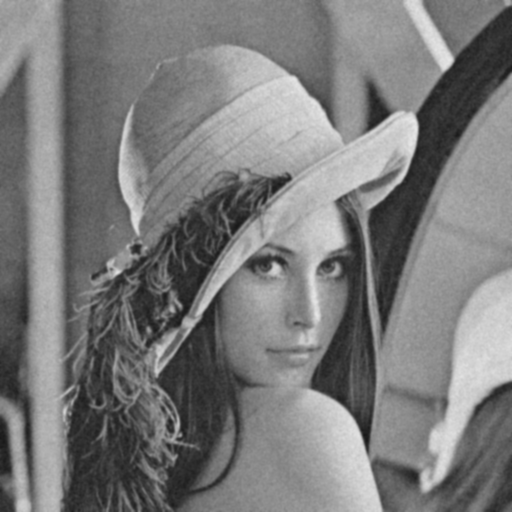

In [17]:
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, gaus_denoised)) + "\n")
print("7x7 Gaussian Filter Result:")
gaus_denoised

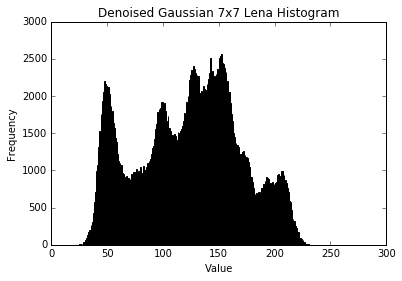

In [18]:
plot_histogram(gaus_denoised, "Denoised Gaussian 7x7 Lena Histogram")

**1. Compare the visual difference between the denoised image from the Gaussian filtering kernel and the denoised images from the averaging filter kernels. Are there any differences? Why? Did the PSNR decrease? Why?**

The Gaussian filter does a much better job of elminating the noise and evening out the colours without creating a ton of blurring. The Gaussian filtered image appears much sharper than either of the averaged filters. This is because the Gaussian filter take a much better average of the pixel values surrounding the pixel in question. This means edge pixels retain their levels better in the resulting image.

The PSNR increased to the level of the 3x3 denoised image. The PSNR increase is because of the noise reduction and better edge preservation by the Gaussian filter. 

**2. Compare the histograms of the denoised image using the Gaussian filtering kernel and the denoised images from the averaging filter kernels. What are the differences? Why?**

The histogram of the Gaussian filtered image does have a reduction or increase in the range of values from the original image (~40 - 240). It can also be seen that the majority of the peaks and valleys are preserved and match to the original image. 

In comparison to the 7x7 averaging filter the histogram of the Gaussian filter has much more gradual slopes. In comparison to the 3x3 filter the 4 main peaks have almost equal values of pixels at that intensity. 

**3. Based on visual quality of the denoised image, what are the benefits and drawbacks associated with using a Gaussian kernel as opposed to an averaging kernel?**

The Gaussian kernel does a muh better job of eliminating the noise while preserving the edges. The edges on the Gaussian kernel are better than both the 3x3 and 7x7 averaging filters.

However you can still see some noise in the image on areas that are more solid intensities, in comparision to the 7x7 filter where these look more consistent in color. 

## Salt and Pepper Noise:

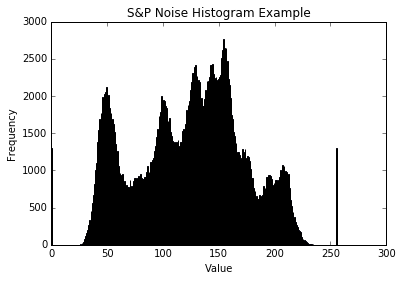

S&P Noise Image:


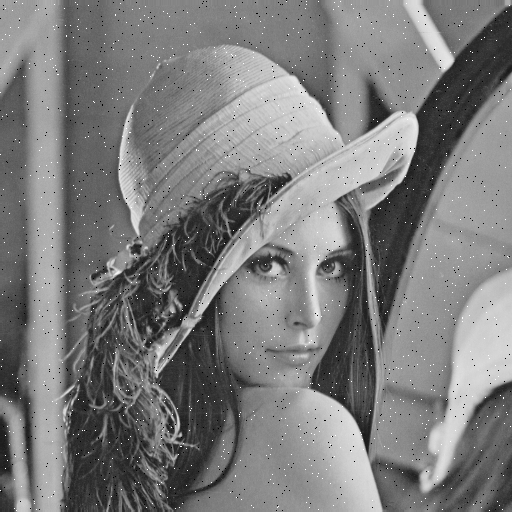

In [19]:
lena_sp = salt_pepper_noise(lena, 0.01)
plot_histogram(lena_sp, "S&P Noise Histogram Example")
print("S&P Noise Image:")
lena_sp

### Gaussian 7x7 Filter (S&P Noise):

PSNR between Lena and Gaussian De-S&P Lena: 31.400825778339637

S&P Denoised with Gaussian 7x7 Filter:


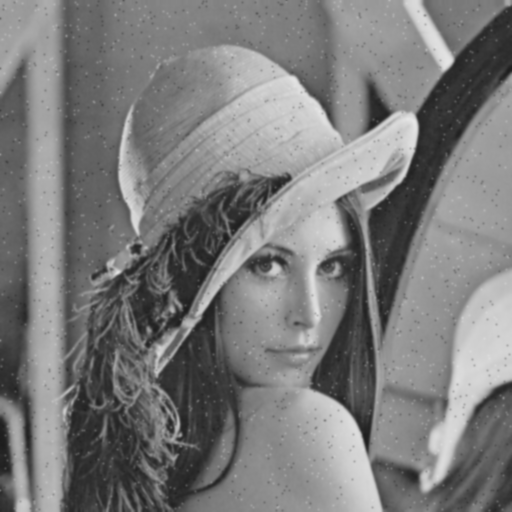

In [20]:
gaus =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

sp_denoised1 = Image.fromarray(ndimage.convolve(np.array(lena_sp), gaus), 'L')
print("PSNR between Lena and Gaussian De-S&P Lena: " + str(PSNR(lena, sp_denoised1)) + "\n")
print("S&P Denoised with Gaussian 7x7 Filter:")
sp_denoised1

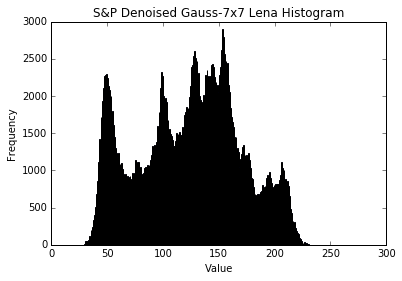

In [21]:
plot_histogram(sp_denoised1, "S&P Denoised Gauss-7x7 Lena Histogram")

### Averaging 7x7 Filter (S&P Noise):

PSNR between Lena and Average De-S&P Lena: 27.319440027235792

S&P Denoised by 7x7 Average Filter:


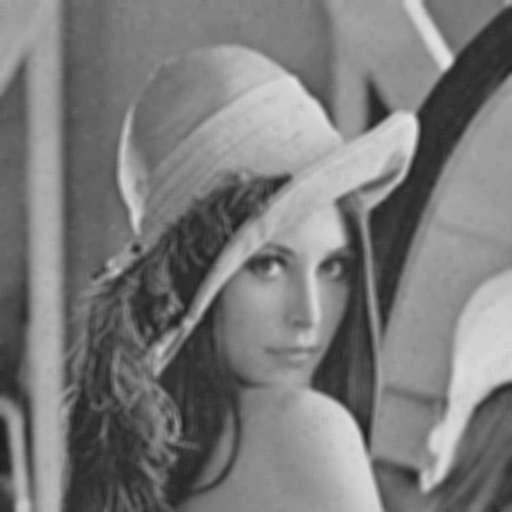

In [22]:
avg_7_7 = (1/(7*7))*np.ones([7,7])

sp_denoised2 = Image.fromarray(ndimage.convolve(np.array(lena_sp), avg_7_7), 'L')
print("PSNR between Lena and Average De-S&P Lena: " + str(PSNR(lena, sp_denoised2)) + "\n")
print("S&P Denoised by 7x7 Average Filter:")
sp_denoised2

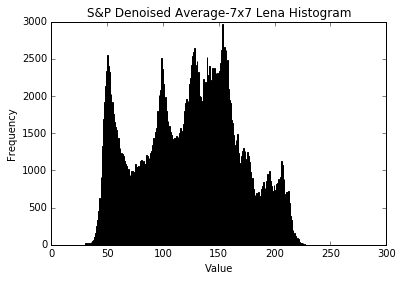

In [23]:
plot_histogram(sp_denoised2, "S&P Denoised Average-7x7 Lena Histogram")

**1. How does the averaging filter and Gaussian filtering methods perform on the nosiy image in terms of noise reduction? Explain in terms of visual quality as well as PSNR. Why do we get such results?**

The Gaussian filter simply reduces the 0 and 255 pixels to more middle values. Unfortunately it doesn't change them enough as you can still see almost all of the pixels that where previously S&P noise. However the Gaussian filter does help preserve the edges and sharpness of the image. 

The averaging filter does a much better job of elminiating the individual S&P pixels. Many of them dissapear or are much more faded. However overall the image seems a lot blurrier/smoother than both the original noisy image and the Gaussian filtered image. 

However, the PSNR shows a much different result. The PSNR of the Gaussian filtered image is actually lower than the PSNR of the average filtered image. This is most likely because the averaging filter does a better job of reducing the noise intensity. 

**2. Compare histograms of denoised images with that of the noisy image. What characteristics are present in all histograms? Why?**

The histograms are very similar as both remove of the high value of '0' and '255' intensity pixels. Both mantain the range of intensities and the majority of the peaks and valleys. The main difference between the two is that the averaging filter has much more even peaks across all levels while Gaussian filter has one peak that is clearly higher than the others. 

## Median Filter

PSNR between Lena and averaged Lena: 31.576718356881123



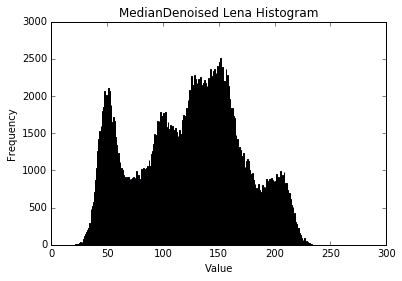

In [24]:
median_denoised = noisy_lena.filter(ImageFilter.MedianFilter())
print("PSNR between Lena and averaged Lena: " + str(PSNR(lena, median_denoised)) + "\n")
plot_histogram(median_denoised, "MedianDenoised Lena Histogram")

Median Filter Result:


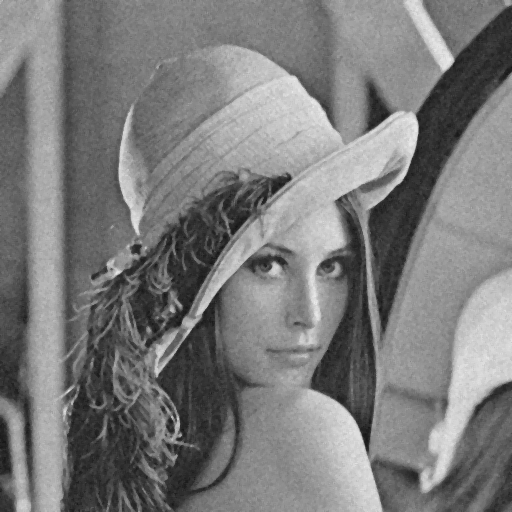

In [25]:
print("Median Filter Result:")
median_denoised

**1. How does the denoised image produced using the median filter compare with denoised images produced using the averaging filter and Gaussian filtering methods? Explain in terms of visual quality as well as PSNR. Why do we get such results with a median filter when compared to the other spatial filtering methods?**

The median filer is better than averaging and gaussian filters at removing anomalies, but in doing so it turns the images into small patches of same valued pixels, a side effect not present in other "blurring" filters. The edge detection of a median filter is much better than other methods. It will effectively identify which side of an edge the pixel is on by recognizing that more of its neighbors are of a particular colour, and assign a colour matching that side of the edge to it. The PSNR is approximately equal to the PSNR of the 3x3 averaging filter.

## Sharpening in Spatial Domain

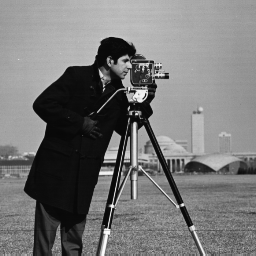

In [26]:
cam

Cameraman Image with Gaussian Filter:


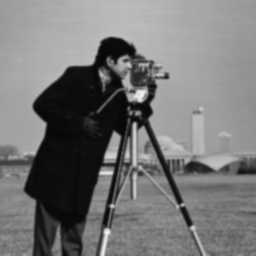

In [27]:
gaus_cam =  np.array([[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0018, 0.0216, 0.0966, 0.1592, 0.0966, 0.0216, 0.0018],
[0.0011, 0.0131, 0.0586, 0.0966, 0.0586, 0.0131, 0.0011],
[0.0002, 0.0029, 0.0131, 0.0216, 0.0131, 0.0029, 0.0002],
[0.0000, 0.0002, 0.0011, 0.0018, 0.0011, 0.0002, 0.0000]]) # because python doesn't have an exact 'fspecial' equivalent

gaus_cam_noised = Image.fromarray(ndimage.convolve(np.array(cam), gaus_cam), 'L')
print("Cameraman Image with Gaussian Filter:")
gaus_cam_noised

Subtracted Image:


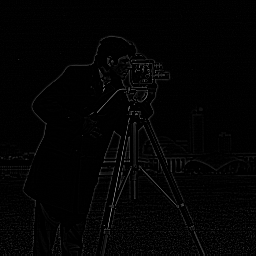

In [28]:
gaus_cam_array = np.array(gaus_cam_noised, dtype=np.int32)
cam_array = np.array(cam, dtype=np.int32)
sub_array = np.array((cam_array - gaus_cam_array).clip(min=0),dtype=np.uint8)
cam_sharp1 = Image.fromarray(sub_array)
print("Subtracted Image:")
cam_sharp1

**1. What does the subtracted image look like? What frequency components from the original image are preserved in the subtracted image? Why?**

The subtracted image looks like a black image of the original with only the edges outlined in white. The frequency components reserved from the original image are the edges. 

The image looks like this because the Gaussian filter is a smoothing function. This means that the edge values are smoothed out to more closer reflect the neighbours around them. A smoothing filter has little effect on large areas of solid colors as the neighbours are all already the same color. 

However when you subtract the Gaussian smoothed image from the original you get a lot of 0 values in areas where there is constant value. The values where there are changes are where edges occured. The sharper the edge the greater the difference between the smoothed pixel values and the original pixel values. This means sharper edges will be more illuminated. 

Subtracted Image Added to Original:


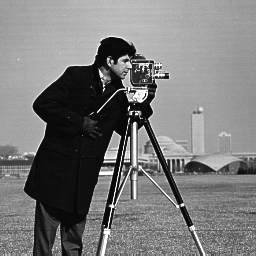

In [29]:
cam_sub_array = np.array(cam_sharp1, dtype=np.int32)
cam_addsub = np.array((np.array(cam_array,dtype=np.int32) + cam_sub_array).clip(max=255), dtype=np.uint8)
cam_sharp2 = Image.fromarray(cam_addsub)
print("Subtracted Image Added to Original:")
cam_sharp2

**1. What does the resulting image look like? How does it differ from the orginal image? Explain why it appears this way.**
The resulting image is an edge-enhanced version of the original image. Adding the subtracted version of the image from the earlier section means that those pixels on the edges getting a boost to their intensity. 

This differs from the original image because the pixel values of the edges are greater than they were before. Thus the edges are more illuminated and more noticeable than in the original. 

PSNR between Cam and Modified Cam: 43.86393214471096

Subtracted Image (0.5 variable) Added to Original:


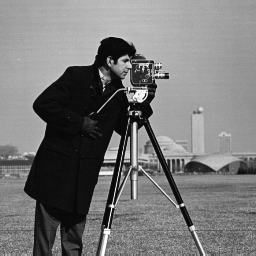

In [30]:
cam_sub_array2 = cam_sub_array ** 0.5
cam_addsub2 = cam_array + cam_sub_array2
cam_sharp3 = Image.fromarray(cam_addsub2)
cam_sharp4 = cam_sharp3.convert('L')
print("PSNR between Cam and Modified Cam: " + str(PSNR(cam, cam_sharp4)) + "\n")
print("Subtracted Image (0.5 variable) Added to Original:")
cam_sharp4

**1. Compare the results produced by adding the subtracting image to original image and that produced by adding half the subtrated image to the original image. How does it differ? Explain why it appears this why?**
The image is still edge enhanced but seemingly less than we had done originally. It differs because the edges are less sharp than they appear in the earlier edge enhanced version. This is because the edge pixels that where added to the original only had half the illumination as did in the earlier section. This means that the edge pixels where only given half as much as they were before. This is why the edges are less noticeable in the second than in the first. 

**2. What does multiplying the subtracted image by a factor less than one accomplish? What about greater than one?**
Multiplying the subtracted image by a factor less than one means that the edge enhancement or addition to the edges is halfed. This does not affect any of the '0' pixels because the multiplication has no affect on their final value. This means that the final image is only edge enhanced half as much as compared to our earlier attempt.

Multiplying by a factor greater than one means that the edge enhanced would be increased by whatever factor you multiplied by. For example if you multiplied by 2 then you would get double the edge enhancement. 